In [1]:
import json

file_path = "/kaggle/input/the-natural-questions-dataset/simplified-nq-train.jsonl"

with open(file_path, "r") as f:
    line = f.readline()
    example = json.loads(line)

print(example.keys())


dict_keys(['document_text', 'long_answer_candidates', 'question_text', 'annotations', 'document_url', 'example_id'])


In [2]:
import json

file_path = "/kaggle/input/the-natural-questions-dataset/simplified-nq-train.jsonl"

with open(file_path, "r") as f:
    f.readline()
    second_line = f.readline()
    example = json.loads(second_line)

print("Question:", example["question_text"])
print("\n --------------------------------")
print("Long answers candidates ",example["long_answer_candidates"])

print("\nDocument snippet:", example["document_text"][:300], "...")

print("\nAnnotations:", example["annotations"])


Question: how i.met your mother who is the mother

 --------------------------------
Long answers candidates  [{'start_token': 28, 'top_level': True, 'end_token': 212}, {'start_token': 29, 'top_level': False, 'end_token': 35}, {'start_token': 35, 'top_level': False, 'end_token': 45}, {'start_token': 45, 'top_level': False, 'end_token': 57}, {'start_token': 57, 'top_level': False, 'end_token': 79}, {'start_token': 79, 'top_level': False, 'end_token': 91}, {'start_token': 91, 'top_level': False, 'end_token': 103}, {'start_token': 103, 'top_level': False, 'end_token': 113}, {'start_token': 113, 'top_level': False, 'end_token': 118}, {'start_token': 118, 'top_level': False, 'end_token': 127}, {'start_token': 127, 'top_level': False, 'end_token': 135}, {'start_token': 135, 'top_level': False, 'end_token': 147}, {'start_token': 147, 'top_level': False, 'end_token': 168}, {'start_token': 168, 'top_level': False, 'end_token': 203}, {'start_token': 203, 'top_level': False, 'end_token': 211}, {'

In [3]:
count = 0
with open(file_path, "r") as f:
    for _ in f:
        count += 1
print("Total examples:", count)


Total examples: 307373


In [10]:
!pip install transformers datasets peft

In [11]:
questions = []
long_answers = []
short_answers = []
long_answer_starts = [] 

with open(file_path, "r") as f:
    for line in f:
        example = json.loads(line)
        
        annotations = example.get('annotations', [])
        if not annotations:
            continue
        
        annotation = annotations[0] 
        short_ans = annotation.get('short_answers', [])
        long_ans = annotation.get('long_answer', None)
        
        if not short_ans or long_ans is None:
            continue
        
        doc_tokens = example['document_text'].split()
        long_start = long_ans['start_token']
        long_end = long_ans['end_token']
        long_text = " ".join(doc_tokens[long_start:long_end])
        
        short_start = short_ans[0]['start_token'] 
        short_end = short_ans[0]['end_token']
        
        questions.append(example['question_text'])
        long_answers.append(long_text)
        long_answer_starts.append(long_start) 
        short_answers.append({
            "start_token": short_start,
            "end_token": short_end
        })

print("Total usable examples:", len(questions))


Total usable examples: 106926


In [13]:
short_answer_count = 0
long_only_count = 0
no_answer_count = 0

with open(file_path, "r") as f:
    for line in f:
        example = json.loads(line)
        annotations = example.get('annotations', [])
        if not annotations:
            no_answer_count += 1
            continue
        annotation = annotations[0]
        short_ans = annotation.get('short_answers', [])
        long_ans = annotation.get('long_answer', None)

        if short_ans and long_ans is not None:
            short_answer_count += 1  
        elif long_ans is not None:
            long_only_count += 1 
        else:
            no_answer_count += 1

print("Examples usable for BERT (short + long):", short_answer_count)
print("Examples with only long answer:", long_only_count)
print("Examples with no answers:", no_answer_count)


Examples usable for BERT (short + long): 106926
Examples with only long answer: 200447
Examples with no answers: 0


In [16]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizerFast

class NQBertDataset(Dataset):
    def __init__(self, questions, long_answers, short_answers, long_answer_starts, max_length=512):
        self.questions = questions
        self.passages = long_answers
        self.short_answers = short_answers
        self.long_starts = long_answer_starts
        self.tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
        self.max_length = max_length

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        passage = self.passages[idx]
        short_ans = self.short_answers[idx]
        
        
        rel_start = short_ans['start_token'] - self.long_starts[idx]
        rel_end = short_ans['end_token'] - self.long_starts[idx]

        encoding = self.tokenizer(
            question,
            passage,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_offsets_mapping=True
        )

        offsets = encoding['offset_mapping']
        input_ids = torch.tensor(encoding['input_ids'])
        attention_mask = torch.tensor(encoding['attention_mask'])
        token_type_ids = torch.tensor(encoding['token_type_ids'])

        passage_words = passage.split()
        char_start = len(" ".join(passage_words[:rel_start])) + (1 if rel_start > 0 else 0)
        char_end = len(" ".join(passage_words[:rel_end]))

        start_token = end_token = 0
        for i, (s, e) in enumerate(offsets):
            if token_type_ids[i] == 1: 
                if s <= char_start < e:
                    start_token = i
                if s < char_end <= e:
                    end_token = i
                    break

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "token_type_ids": token_type_ids,
            "start_positions": torch.tensor(start_token),
            "end_positions": torch.tensor(end_token)
        }

In [98]:
# 1. Setup the dataset
test_ds = NQBertDataset(questions, long_answers, short_answers, long_answer_starts)

# 2. Pick an index to check
idx = 40 

# 3. Get the processed data from the class
data_item = test_ds[idx]

# 4. Extract the pieces
input_ids = data_item['input_ids']
token_type_ids = data_item['token_type_ids']
start_idx = data_item['start_positions'].item()
end_idx = data_item['end_positions'].item()

# 5. Decode the FULL Passage (where token_type_ids == 1)
# This is exactly what BERT sees as the "context"
passage_tokens = input_ids[token_type_ids == 1]
full_passage_text = tokenizer.decode(passage_tokens, skip_special_tokens=True)

# 6. Decode the Short Answer Label
predicted_gold_words = tokenizer.decode(input_ids[start_idx : end_idx + 1])

print(f"--- Dataset Verification (Index {idx}) ---")
print(f"Question: {questions[idx]}")
print("-" * 30)
print(f"FULL LONG ANSWER (Passage):\n{full_passage_text}")
print("-" * 30)
print(f"LABEL INDICES: Start={start_idx}, End={end_idx}")
print(f"SHORT ANSWER LABEL: [{predicted_gold_words}]")

# 7. Final Sanity Check
if predicted_gold_words.strip() in full_passage_text:
    print("\n✅ SUCCESS: The short answer exists inside the long answer!")
    if len(predicted_gold_words.split()) < 15: # Increased limit slightly for descriptive answers
        print("✅ SUCCESS: It is a concise span.")
else:
    print("\n❌ ERROR: The label points to text NOT in the passage!")

--- Dataset Verification (Index 40) ---
Question: the pair of hand drums used in indian classical music is called
------------------------------
FULL LONG ANSWER (Passage):
< p > the tabla consists of two single headed, barrel shaped small drums of slightly different size and shapes : daya also called dahina meaning right ( also called ` ` tabla ' ' ), and baya also called bahina meaning left ( also called ` ` dagga ' ' ). the daya tabla is played by the musician ' s right hand ( dominant hand ), and is about 15 centimetres ( ~ 6 in ) in diameter and 25 centimetres ( ~ 10 in ) high. the baya tabla is a bit bigger and deep kettledrum shaped, about 20 centimetres ( ~ 8 in ) in diameter and 25 centimetres ( ~ 10 in ) in height. each is made of hollowed out wood or clay or brass, the daya drum laced with hoops, thongs and wooden dowels on its sides. the dowels and hoops are used to tighten the tension of the membrane. the daya is tuned to the ground note of the raga called sa ( tonic in in

In [17]:
full_dataset = NQBertDataset(questions, long_answers, short_answers,long_answer_starts)

total_len = len(full_dataset)
train_len = int(0.9 * total_len)
val_len = int(0.05 * total_len)
test_len = total_len - train_len - val_len

from torch.utils.data import random_split
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)
)

print("Train examples:", len(train_dataset))
print("Validation examples:", len(val_dataset))
print("Test examples:", len(test_dataset))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Train examples: 96233
Validation examples: 5346
Test examples: 5347


In [23]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [24]:
from transformers import BertForQuestionAnswering

model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "value"],
    bias="none",
    task_type="QUESTION_ANS"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 296,450 || all params: 109,189,636 || trainable%: 0.2715


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [27]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)

model.to(device)


Using 2 GPUs


DataParallel(
  (module): PeftModelForQuestionAnswering(
    (base_model): LoraModel(
      (model): PeftModelForQuestionAnswering(
        (base_model): LoraModel(
          (model): BertForQuestionAnswering(
            (bert): BertModel(
              (embeddings): BertEmbeddings(
                (word_embeddings): Embedding(30522, 768, padding_idx=0)
                (position_embeddings): Embedding(512, 768)
                (token_type_embeddings): Embedding(2, 768)
                (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (encoder): BertEncoder(
                (layer): ModuleList(
                  (0-11): 12 x BertLayer(
                    (attention): BertAttention(
                      (self): BertSdpaSelfAttention(
                        (query): lora.Linear(
                          (base_layer): Linear(in_features=768, out_features=768, bias=True)
            

In [55]:
num_train_epochs = 5
weight_decay = 0.01      
gradient_accumulation_steps = 1  
max_seq_length = 512     
learning_rate = 3e-4

In [56]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)


In [79]:
def compute_em_f1(pred_text, gold_texts):
    import collections
    
    def normalize(s):
        return " ".join(s.lower().split())

    pred_tokens = normalize(pred_text).split()
    em = max([int(normalize(g) == normalize(pred_text)) for g in gold_texts])
    
    f1_scores = []
    for g in gold_texts:
        g_tokens = normalize(g).split()
        common = collections.Counter(pred_tokens) & collections.Counter(g_tokens)
        num_same = sum(common.values())
        if num_same == 0:
            f1_scores.append(0)
        else:
            precision = num_same / len(pred_tokens)
            recall = num_same / len(g_tokens)
            f1_scores.append(2 * precision * recall / (precision + recall))
    f1 = max(f1_scores)
    return em, f1


In [58]:
import re
import string

def normalize(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    
    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [59]:
import os

output_dir = "/kaggle/working/bertqa_lora"
os.makedirs(output_dir, exist_ok=True)

In [60]:
from tqdm import tqdm

for epoch in range(num_train_epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    total_loss = 0
    
    for step, batch in enumerate(loop):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            start_positions=start_positions,
            end_positions=end_positions,
            return_dict=True
        )
        
        loss = outputs.loss.mean()
        loss.backward()
        
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            
        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} Complete. Average Loss: {avg_loss:.4f}")

    pt_filename = f"bertqa_lora_reader_epoch{epoch+1}.pt"
    pt_save_path = os.path.join(output_dir, pt_filename)
    
    state_to_save = model.module.state_dict() if hasattr(model, 'module') else model.state_dict()
    
    torch.save(state_to_save, pt_save_path)
    print(f"Weights saved to: {pt_save_path}")

Epoch 1: 100%|██████████| 12030/12030 [1:25:29<00:00,  2.35it/s, loss=1.1]  



Epoch 1 Complete. Average Loss: 1.6621
Weights saved to: /kaggle/working/bertqa_lora/bertqa_lora_reader_epoch1.pt


Epoch 2: 100%|██████████| 12030/12030 [1:25:38<00:00,  2.34it/s, loss=0.179]



Epoch 2 Complete. Average Loss: 1.3217
Weights saved to: /kaggle/working/bertqa_lora/bertqa_lora_reader_epoch2.pt


Epoch 3: 100%|██████████| 12030/12030 [1:25:43<00:00,  2.34it/s, loss=0.133]



Epoch 3 Complete. Average Loss: 1.2211
Weights saved to: /kaggle/working/bertqa_lora/bertqa_lora_reader_epoch3.pt


Epoch 4: 100%|██████████| 12030/12030 [1:25:45<00:00,  2.34it/s, loss=0.0743]



Epoch 4 Complete. Average Loss: 1.1600
Weights saved to: /kaggle/working/bertqa_lora/bertqa_lora_reader_epoch4.pt


Epoch 5: 100%|██████████| 12030/12030 [1:25:30<00:00,  2.34it/s, loss=0.431]



Epoch 5 Complete. Average Loss: 1.1220
Weights saved to: /kaggle/working/bertqa_lora/bertqa_lora_reader_epoch5.pt


In [61]:
if isinstance(model, torch.nn.DataParallel):
    model.config = model.module.config
    print("Model attributes fixed for evaluation.")

Model attributes fixed for evaluation.


In [80]:
def get_gold_answer(batch, tokenizer):
    gold_answers = []

    for i in range(batch["input_ids"].size(0)):
        input_ids = batch["input_ids"][i]
        start = batch["start_positions"][i].item()
        end = batch["end_positions"][i].item()

        tokens = tokenizer.convert_ids_to_tokens(input_ids[start:end+1])
        gold_text = tokenizer.convert_tokens_to_string(tokens)

        gold_answers.append(gold_text)

    return gold_answers


In [81]:
def get_predicted_answer(batch, outputs, tokenizer):
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    start_idx = torch.argmax(start_logits, dim=1)
    end_idx = torch.argmax(end_logits, dim=1)

    answers = []

    for i in range(len(start_idx)):
        s = start_idx[i].item()
        e = end_idx[i].item()

        if e < s:
            e = s

        input_ids = batch["input_ids"][i]
        tokens = tokenizer.convert_ids_to_tokens(input_ids[s:e+1])
        answer = tokenizer.convert_tokens_to_string(tokens)

        answers.append(answer)

    return answers


In [82]:
def evaluate_qa(model, dataloader, tokenizer, device):
    model_to_run = model.module if isinstance(model, torch.nn.DataParallel) else model
    
    model_to_run.eval()
    all_em = []
    all_f1 = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model_to_run(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                token_type_ids=batch["token_type_ids"],
                return_dict=True 
            )

            pred_answers = get_predicted_answer(batch, outputs, tokenizer)
            gold_answers = get_gold_answer(batch, tokenizer)

            for pred, gold in zip(pred_answers, gold_answers):
                em, f1 = compute_em_f1(pred, [gold])
                all_em.append(em)
                all_f1.append(f1)

    return np.array(all_em), np.array(all_f1)

In [83]:
import numpy as np
tokenizer = full_dataset.tokenizer

val_em, val_f1 = evaluate_qa(
    model=model,
    dataloader=val_loader,
    tokenizer=tokenizer,
    device=device
)

100%|██████████| 669/669 [02:48<00:00,  3.98it/s]


In [84]:
test_em, test_f1 = evaluate_qa(
    model=model,
    dataloader=test_loader,
    tokenizer=tokenizer,
    device=device
)

100%|██████████| 669/669 [02:48<00:00,  3.97it/s]


In [85]:
print(f"\n{'='*30}")
print(f"VAL RESULTS:  EM: {val_em.mean()*100:.2f}% | F1: {val_f1.mean()*100:.2f}%")
print(f"TEST RESULTS: EM: {test_em.mean()*100:.2f}% | F1: {test_f1.mean()*100:.2f}%")
print(f"{'='*30}")

best_idx = np.argmax(test_f1)
print(f"Best Test Example F1: {test_f1[best_idx]}")


VAL RESULTS:  EM: 58.27% | F1: 71.46%
TEST RESULTS: EM: 59.23% | F1: 72.18%
Best Test Example F1: 1.0


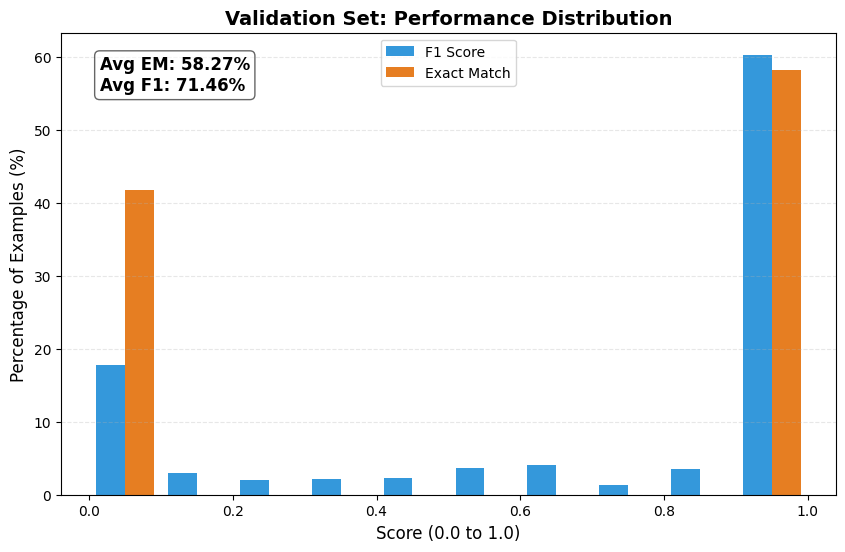

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt


val_em_avg = val_em.mean()
val_f1_avg = val_f1.mean()

plt.figure(figsize=(10, 6))

plt.hist([val_f1, val_em], bins=10, range=(0, 1), 
         color=['#3498db', '#e67e22'], 
         label=['F1 Score', 'Exact Match'],
         weights=[np.ones(len(val_f1))/len(val_f1)*100, 
                  np.ones(len(val_em))/len(val_em)*100])

plt.title("Validation Set: Performance Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Score (0.0 to 1.0)", fontsize=12)
plt.ylabel("Percentage of Examples (%)", fontsize=12)
plt.legend(loc='upper center')

stats_text = f"Avg EM: {val_em_avg*100:.2f}%\nAvg F1: {val_f1_avg*100:.2f}%"
plt.gca().text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
               fontsize=12, verticalalignment='top', fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.savefig('validation_performance.png', dpi=300, bbox_inches='tight')
plt.show()

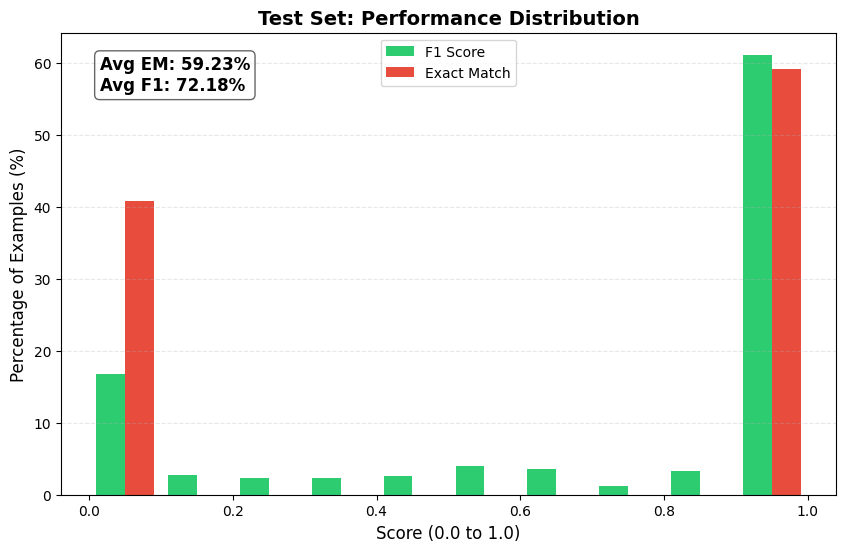

In [89]:
test_em_avg = test_em.mean()
test_f1_avg = test_f1.mean()

plt.figure(figsize=(10, 6))

plt.hist([test_f1, test_em], bins=10, range=(0, 1), 
         color=['#2ecc71', '#e74c3c'], 
         label=['F1 Score', 'Exact Match'],
         weights=[np.ones(len(test_f1))/len(test_f1)*100, 
                  np.ones(len(test_em))/len(test_em)*100])

plt.title("Test Set: Performance Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Score (0.0 to 1.0)", fontsize=12)
plt.ylabel("Percentage of Examples (%)", fontsize=12)
plt.legend(loc='upper center')

stats_text = f"Avg EM: {test_em_avg*100:.2f}%\nAvg F1: {test_f1_avg*100:.2f}%"
plt.gca().text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
               fontsize=12, verticalalignment='top', fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.savefig('test_performance.png', dpi=300, bbox_inches='tight')
plt.show()

In [98]:
import torch
import random

def test_and_compare(model, dataset, tokenizer, device, num_samples=3):
    model.eval()
    model_to_run = model.module if hasattr(model, 'module') else model
    
    indices = random.sample(range(len(dataset)), num_samples)
    
    print(f"--- PREDICTING ON {num_samples} RANDOM EXAMPLES ---")
    print("-" * 50)

    for idx in indices:
        batch = dataset[idx]
        
        input_ids = batch['input_ids'].unsqueeze(0).to(device)
        attention_mask = batch['attention_mask'].unsqueeze(0).to(device)
        token_type_ids = batch['token_type_ids'].unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model_to_run(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                return_dict=True
            )

        start_pred = torch.argmax(outputs.start_logits).item()
        end_pred = torch.argmax(outputs.end_logits).item()
        
        start_gold = batch['start_positions'].item()
        end_gold = batch['end_positions'].item()

        all_tokens = tokenizer.convert_ids_to_tokens(batch['input_ids'])
        
       
        sep_index = batch['input_ids'].tolist().index(tokenizer.sep_token_id)
        
        question = tokenizer.decode(batch['input_ids'][1:sep_index], skip_special_tokens=True)
        long_answer = tokenizer.decode(batch['input_ids'][sep_index+1:], skip_special_tokens=True)
        
        pred_short = tokenizer.decode(batch['input_ids'][start_pred:end_pred+1], skip_special_tokens=True)
        actual_short = tokenizer.decode(batch['input_ids'][start_gold:end_gold+1], skip_special_tokens=True)

        print(f"QUESTION: {question}")
        print(f"\nLONG ANSWER (CONTEXT):\n{long_answer[:600]}...") 
        print(f"\nPREDICTED SHORT ANSWER: [{pred_short}]")
        print(f"ACTUAL SHORT ANSWER:    [{actual_short}]")
        
        match = " SUCCESS" if pred_short.strip().lower() == actual_short.strip().lower() else "❌ MISMATCH"
        print(f"RESULT: {match}")
        print("=" * 80)


test_and_compare(model, test_dataset, tokenizer, device, num_samples=5)

--- PREDICTING ON 5 RANDOM EXAMPLES ---
--------------------------------------------------
QUESTION: where does the saying groundhog day come from

LONG ANSWER (CONTEXT):
< p > the first documented american reference to groundhog day can be found in a diary entry, dated february 4, 1841, by morgantown, pennsylvania, storekeeper james morris : < / p >...

PREDICTED SHORT ANSWER: [a diary entry, dated february 4, 1841, by morgantown, pennsylvania, storekeeper james morris]
ACTUAL SHORT ANSWER:    [a diary entry, dated february 4, 1841, by morgantown, pennsylvania, storekeeper james morris]
RESULT:  SUCCESS
QUESTION: who does the voice of lilo in lilo and stitch

LONG ANSWER (CONTEXT):
< li > daveigh chase as lilo pelekai, an eccentric young hawaiian girl on the island of kaua ' i who adopts stitch as her pet dog. andreas deja served as the supervising animator for lilo pelekai. < / li >...

PREDICTED SHORT ANSWER: [daveigh chase]
ACTUAL SHORT ANSWER:    [daveigh chase]
RESULT:  SUCCESS
Q

In [95]:
def analyze_failures(model, dataloader, tokenizer, device, num_to_show=5):
    model.eval()
    failures = []

    print("Searching for the hardest questions...")
    with torch.no_grad():
        for batch in dataloader:
            inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'token_type_ids']}
            outputs = model(**inputs)
            
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits
            
            for i in range(len(start_logits)):
                s_pred = torch.argmax(start_logits[i]).item()
                e_pred = torch.argmax(end_logits[i]).item()
                
                s_gold = batch['start_positions'][i].item()
                e_gold = batch['end_positions'][i].item()
                
                pred_text = tokenizer.decode(batch['input_ids'][i][s_pred:e_pred+1], skip_special_tokens=True)
                gold_text = tokenizer.decode(batch['input_ids'][i][s_gold:e_gold+1], skip_special_tokens=True)
                
                em, f1 = compute_em_f1(pred_text, [gold_text])
                
                if f1 == 0: 
                    question = tokenizer.decode(batch['input_ids'][i], skip_special_tokens=True).split('?')[0] + '?'
                    failures.append({
                        'question': question,
                        'pred': pred_text,
                        'gold': gold_text
                    })
            
            if len(failures) >= num_to_show:
                break

    print(f"\n--- TOP {num_to_show} HARDEST QUESTIONS (F1 = 0) ---")
    for j, failure in enumerate(failures[:num_to_show]):
        print(f"{j+1}. Q: {failure['question']}")
        print(f"   Model guessed: [{failure['pred']}]")
        print(f"   Actual Answer: [{failure['gold']}]")
        print("-" * 30)

analyze_failures(model, test_loader, tokenizer, device)

Searching for the hardest questions...

--- TOP 5 HARDEST QUESTIONS (F1 = 0) ---
1. Q: in one word what is the primarily driving force for deep currents < p > warm seawater expands and is thus less dense than cooler seawater. saltier water is denser than fresher water because the dissolved salts fill interstices between water molecules, resulting in more mass per unit volume. lighter water masses float over denser ones ( just as a piece of wood or ice will float on water, see buoyancy ). this is known as ` ` stable stratification ' ' as opposed to unstable stratification ( see bruunt - vaisala frequency ) where denser waters are located over less dense waters ( see convection or deep convection needed for water mass formation ). when dense water masses are first formed, they are not stably stratified, so they seek to locate themselves in the correct vertical position according to their density. this motion is called convection, it orders the stratification by gravitation. driven by the

In [103]:
import collections
import torch
import numpy as np

def analyze_by_question_type(model, dataloader, tokenizer, device):
    model.eval()
    categories = ["what", "who", "when", "where", "how", "why", "which"]
    results_f1 = collections.defaultdict(list)
    results_em = collections.defaultdict(list)
    total_processed = 0

    print("Analyzing all questions (EM and F1)...")
    
    with torch.no_grad():
        for batch in dataloader:
            inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask', 'token_type_ids']}
            outputs = model(**inputs)
            
            for i in range(len(batch['input_ids'])):
                total_processed += 1
                
                full_text = tokenizer.decode(batch['input_ids'][i], skip_special_tokens=True).lower()
                question_text = full_text.split('?')[0].strip()
                words = question_text.split()
                first_word = words[0] if len(words) > 0 else ""

                category = "other"
                for c in categories:
                    if first_word == c:
                        category = c
                        break
                
                s_pred = torch.argmax(outputs.start_logits[i]).item()
                e_pred = torch.argmax(outputs.end_logits[i]).item()
                s_gold = batch['start_positions'][i].item()
                e_gold = batch['end_positions'][i].item()
                
                pred_text = tokenizer.decode(batch['input_ids'][i][s_pred:e_pred+1], skip_special_tokens=True)
                gold_text = tokenizer.decode(batch['input_ids'][i][s_gold:e_gold+1], skip_special_tokens=True)
                
                em, f1 = compute_em_f1(pred_text, [gold_text])
                results_em[category].append(em)
                results_f1[category].append(f1)

    print(f"\n{'Question Type':<12} | {'Count':<6} | {'Avg EM':<10} | {'Avg F1':<10}")
    print("-" * 48)
    
    total_em_list = []
    total_f1_list = []
    
    for cat in sorted(results_f1.keys()):
        avg_em = np.mean(results_em[cat]) * 100
        avg_f1 = np.mean(results_f1[cat]) * 100
        count = len(results_f1[cat])
        
        total_em_list.extend(results_em[cat])
        total_f1_list.extend(results_f1[cat])
        
        print(f"{cat:<12} | {count:<6} | {avg_em:>8.2f}% | {avg_f1:>8.2f}%")
    
    print("-" * 48)
    overall_em = np.mean(total_em_list) * 100
    overall_f1 = np.mean(total_f1_list) * 100
    print(f"{'OVERALL':<12} | {len(total_f1_list):<6} | {overall_em:>8.2f}% | {overall_f1:>8.2f}%")

analyze_by_question_type(model, test_loader, tokenizer, device)

Analyzing all questions (EM and F1)...

Question Type | Count  | Avg EM     | Avg F1    
------------------------------------------------
how          | 304    |    56.58% |    61.55%
other        | 615    |    48.29% |    57.68%
what         | 796    |    43.47% |    56.80%
when         | 1023   |    67.16% |    67.91%
where        | 583    |    38.25% |    63.48%
which        | 97     |    53.61% |    61.44%
who          | 1906   |    72.67% |    75.56%
why          | 23     |     0.00% |    30.81%
------------------------------------------------
OVERALL      | 5347   |    59.14% |    66.68%


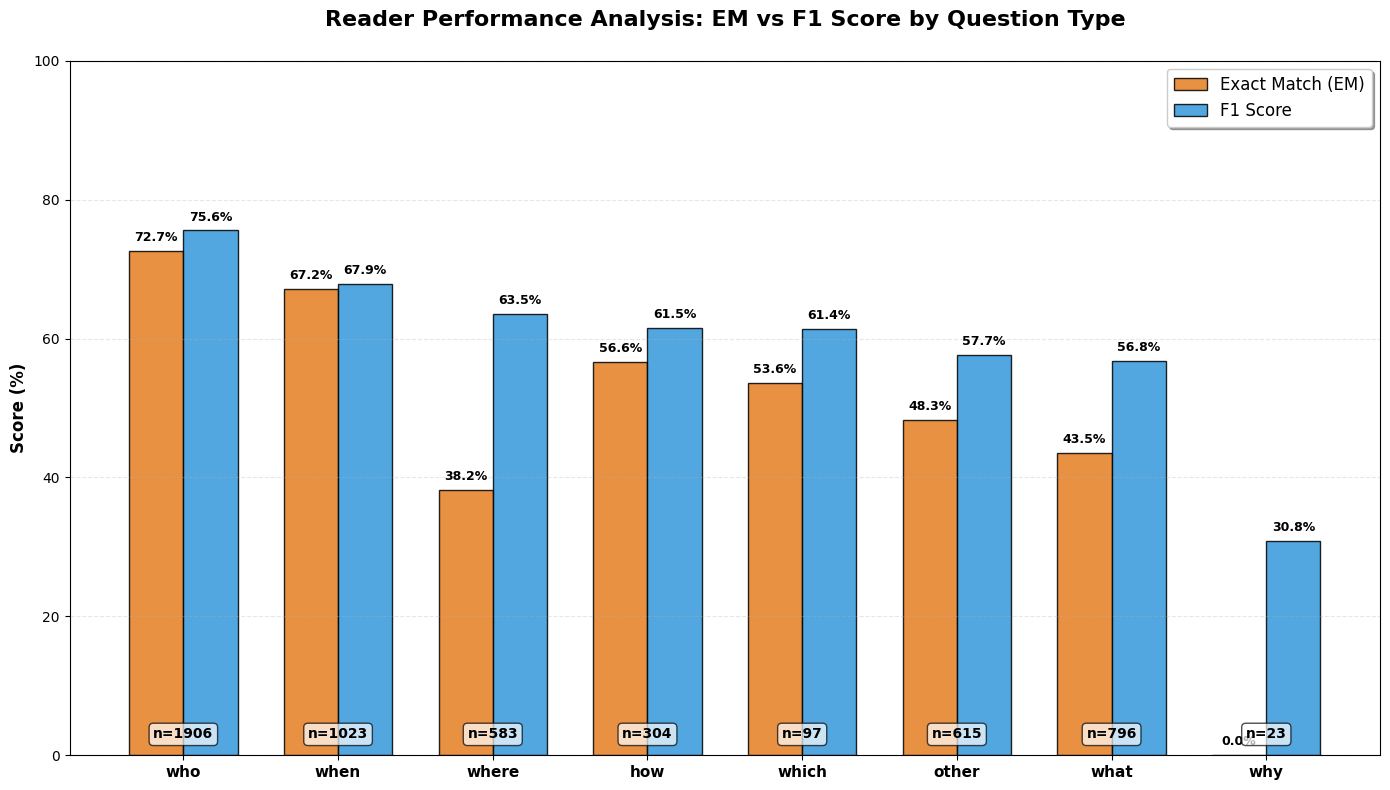

In [104]:
import matplotlib.pyplot as plt
import numpy as np

data = {
    'how': {'count': 304, 'em': 56.58, 'f1': 61.55},
    'other': {'count': 615, 'em': 48.29, 'f1': 57.68},
    'what': {'count': 796, 'em': 43.47, 'f1': 56.80},
    'when': {'count': 1023, 'em': 67.16, 'f1': 67.91},
    'where': {'count': 583, 'em': 38.25, 'f1': 63.48},
    'which': {'count': 97, 'em': 53.61, 'f1': 61.44},
    'who': {'count': 1906, 'em': 72.67, 'f1': 75.56},
    'why': {'count': 23, 'em': 0.00, 'f1': 30.81}
}

sorted_keys = sorted(data.keys(), key=lambda x: data[x]['f1'], reverse=True)

categories = sorted_keys
em_scores = [data[k]['em'] for k in sorted_keys]
f1_scores = [data[k]['f1'] for k in sorted_keys]
counts = [data[k]['count'] for k in sorted_keys]

x = np.arange(len(categories))
width = 0.35 

plt.figure(figsize=(14, 8))

rects1 = plt.bar(x - width/2, em_scores, width, label='Exact Match (EM)', color='#e67e22', alpha=0.85, edgecolor='black')
rects2 = plt.bar(x + width/2, f1_scores, width, label='F1 Score', color='#3498db', alpha=0.85, edgecolor='black')

plt.ylabel('Score (%)', fontsize=12, fontweight='bold')
plt.title('Reader Performance Analysis: EM vs F1 Score by Question Type', fontsize=16, fontweight='bold', pad=25)
plt.xticks(x, categories, fontsize=11, fontweight='bold')
plt.legend(loc='upper right', fontsize=12, frameon=True, shadow=True)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.3)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

for i, count in enumerate(counts):
    plt.text(i, 2, f'n={count}', ha='center', va='bottom', fontsize=10, color='black', 
             fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

plt.tight_layout()

plt.savefig('qa_performance_by_type.png', dpi=300, bbox_inches='tight')
plt.show()